In [28]:
import sys
#sys.path.append('../shared/')
#import videodisko as vd
# Imports
import numpy as np
import numpy.matlib
import numpy.random

from mpl_toolkits.mplot3d import axes3d 

from matplotlib import pyplot as plt

from scipy import ndimage
from scipy import misc
from scipy import fftpack
from scipy import optimize
import scipy.io
import skimage
import imageio
import colour as c
import math
import csv

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd

import cv2
import time

from datetime import datetime

import os
from fnmatch import fnmatch

In [29]:
def count_unique_variables_3d(array_3d):
    flattened_array = array_3d.flatten()
    unique_variables = np.unique(flattened_array)
    num_unique_variables = len(unique_variables)
    return num_unique_variables

# Example usage:
# Create a 3D array
my_3d_array = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [1, 2, 3]]])

# Call the function
result = count_unique_variables_3d(my_3d_array)

# Print the result
print(f"Number of unique variables in the 3D array: {result}")


Number of unique variables in the 3D array: 9


In [30]:
Matrix_LMS_XYZ = [[1.91020,-1.11212,0.20191],
                  [0.37095,0.62905,0.0],
                  [0.0,0.0,1.0]]

Matrix_BT709_XYZ = [[0.4124564, 0.3575761, 0.1804375],
                    [0.2126729, 0.7151522, 0.0721750],
                    [0.0193339, 0.1191920, 0.9503041]]

Matrix_BT2020_XYZ = [[0.636958, 0.144617, 0.168881],
                    [0.262700, 0.677998, 0.059302],
                    [0.00000, 0.028073, 1.060985]]

Matrix_BT709_BT2020 = [[0.6274, 0.3293, 0.0433],
                        [0.0691, 0.9195, 0.0114],
                        [0.0164, 0.0880, 0.8956]]

Matrix_LogC4_XYZ = [[0.704858320407232064, 0.129760295170463003, 0.115837311473976537],
                        [0.254524176404027025, 0.781477732712002049, -0.036001909116029039],
                        [0.000000000000000000, 0.000000000000000000, 1.089057750759878429]]

Matrix_XYZ_BT2020 = [[1.716651, -0.355671, -0.253366],
                        [-0.666684, 1.616481, 0.015769],
                        [0.017640, -0.042771, 0.942103]]

Matrix_P3_XYZ = c.normalised_primary_matrix([0.68, 0.32, 0.265, 0.69, 0.15, 0.06],[0.3127, 0.3290])

Matrix_XYZ_P3 = np.linalg.inv(Matrix_P3_XYZ)

In [31]:

## Linear to sRGB
def lin2srgb (x):
    result = (x <= 0.0031308) * np.multiply(x,12.92) + (x > 0.0031308) * np.subtract(np.multiply(1.055,np.power(x,(1/2.4))),0.055)
    return result


## sRGB to Linear 
def srgb2lin (x):
    result = (x <= 0.04045) * np.divide(x,12.92) + (x > 0.04045) * np.power(np.divide(np.add(x,0.055),1.055),2.4)
    return result

# SDR Formulas

## Input Luminance between 0-1
## Output Videosignal
def oetf709(x): 
    return np.subtract(np.multiply(np.power(x, 0.45), 1.099), 0.099)*(0.018<= x) + np.multiply(4.5, x) * (x <0.018)

def eotf1886(x, Lw = 100, Lb = 0): 
    gamma = 2.4
    a = np.power(np.subtract(np.power(Lw, np.divide(1,gamma)),np.power(Lb, np.divide(1, gamma))), gamma)
    b = np.divide(np.power(Lb, np.divide(1,gamma)) , np.subtract(np.power(Lw , np.divide(1,gamma)), np.power( Lb , np.divide(1, gamma))))
    return np.multiply(a , np.power( np.maximum(np.add(x, b), 0) , gamma))

def eotf1886_CRT(x, Lw = 100, Lb = 0, b = 0): 
    Vc = 0.35
    a1 = 2.6
    a2 = 3.0
    k = np.subtract(Lw,np.power(np.add(1,b),a1))
    return (x < Vc) * np.multiply(np.multiply(k,np.power(np.add(Vc,b),np.subtract(a1,a2))),np.power(np.add(x,b),a2)) + (Vc <= x) * np.multiply(k,np.power(np.add(x,b),a1))

## Luma Formulas for Rec2020 / Rec709 -> Fixed Addition
def luma709(img): 
    return np.multiply(img[:,:,0],0.2126) + np.multiply(img[:,:,1],0.7152) + np.multiply(img[:,:,2],0.0722)
def luma2020(img): 
    return np.multiply(img[:,:,0],0.2627) + np.multiply(img[:,:,1],0.6780) + np.multiply(img[:,:,2],0.0593)

## Formulas for PQ

# increasing rec.709 formulas 
def steroids709(x): 
    return np.subtract(np.multiply(np.power(np.multiply(59.5208 , x), 0.45), 1.099), 0.099)*(0.0003024< x) + np.multiply(267.84, x) * (x <= 0.0003024)

def steroids1886(x): 
    return np.multiply(100, np.power(x, 2.4))


## Transportfunctions

def pq_eotf(x): 
    ##m1
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    
    return np.multiply(np.power(np.divide(np.maximum( np.subtract( np.power(x , np.divide(1 , m2)), c1) , 0) , np.subtract(c2, np.multiply(c3 , np.power(x , np.divide(1 , m2))))) , np.divide(1, m1)), 10000)

## Inverse_eotf

def pq_eotf_inv(x): 
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    y = np.divide(x , 10000) ## Normalisierung auf 0.00 bis 1.0

    return np.power( np.divide(np.add(c1 , np.multiply(c2 , np.power(y , m1))), np.add(1 , np.multiply(c3 , np.power(y , m1)))), m2)

# RGB Input
def hlg_oetf(x): 
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))

    return np.where(x <= np.divide(1,12), np.sqrt(np.multiply(3,x )), np.add( np.multiply(a , np.log(np.subtract( np.multiply(12 , x ), b))) , c) )

def hlg_oetf_inv(x):
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))
    
    return np.where(x <= 0.5 , np.divide( np.power(x,2), 3), np.divide(np.add(np.exp(np.divide(np.subtract(x , c), a)), b) , 12) )

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf(x, Lw): 
    r = x[: , : , 0]
    g = x[: , : , 1]
    b = x[: , : , 2]
    luma = np.add(np.multiply(0.2627 ,r ), np.multiply(0.678 , g), np.multiply(0.0593 , b))
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    rd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), r)
    gd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), g)
    bd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), b)
    return np.stack((rd , gd , bd))

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf_bw(x, Lw=1000): 
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    return np.multiply(np.multiply( alpha , np.power(x , np.subtract(gamma , 1))),x)

def hlg_eotf(x, Lw = 1000, Lb = 0.005):
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    beta = np.sqrt(np.multiply(3 , np.power(np.divide(Lb , Lw), np.divide(1,gamma))))
    return hlg_ootf_bw(hlg_oetf_inv(np.maximum(0 , (np.add( np.multiply( np.subtract(1 , beta), x ), beta)))), Lw)


def slog3oetf(x): 
    # reflection add
    x = x*0.9

    return (x < 0.01125)* np.divide( np.add( np.multiply(x , np.divide(np.subtract(171.2102946929, 95), 0.01125)), 95), 1023) + (x >= 0.01125)* np.divide(np.add(420 , np.multiply( np.log10(np.divide(np.add(x,0.01), np.add(0.18, 0.01))), 261.5)), 1023)

def slog3eotf(x): 
    return (x >= np.divide(171.2102946929,1023)) * np.subtract( np.multiply(np.power(10 , np.divide( np.subtract(420 , np.multiply(x , 1023)) , 261.5)) , np.add(0.18 , 0.01)) , 0.01) + (x < np.divide(171.2102946929,1023)) * np.multiply(np.subtract(np.multiply(x , 1023), 95 ) , np.divide(0.01125 , np.subtract(171.2102946929 , 95)))

# These are the ARRI LogCv3 Formulas
def lin2logc(x):
    return np.multiply(x > 0.010591, 0.24719 * np.log10(5.555556 * x + 0.052272) + 0.385537) + np.multiply(x <= 0.010591, 5.367655 * x + 0.092809)
def logc2lin(x):
    return np.multiply(x > 0.149659, (np.power(10.0, (x - 0.385537) / 0.247189) - 0.052272) / 5.555556) + np.multiply(x <= 0.149659, (x - 0.092809) / 5.367650)


### LOG C4
def Encoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < t) * np.divide(np.subtract(x,t),s) + (x >= t) * np.add(np.multiply(np.divide( np.subtract(np.log2(np.add(np.multiply(a,x),64.0)),6.0),14.0),b),c)

def Decoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < 0.0) * np.add(np.multiply(x,s),t) + (x >= 0.0) * np.divide(np.subtract(np.power(2.0, np.add(np.multiply(14,np.divide(np.subtract(x,c),b)),6)),64.0),a)


def full2legal(x):
    return (219*(x)+16)*np.power(2,(10-8))

def legal2full(x):
    return (((x/np.power(2,(10-8)))-16)/219)

def lin2log2(x):
    return np.log2(x)

def log22lin(x):
    return np.power(2,x)

def Blenden_Differenz(num1, num2):
    new2 = num2 / num1
    return np.log2(new2)

def mse_calculation(imageA, imageB):
    # Expects Luma Images
	err = np.mean(np.square(np.subtract(imageA,imageB)))
	return err

## ARRI LUTs to BT.2020 and P3

In [4]:
ARRI_LogC3_LUT_1000k_DW_200_P3_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC3_v1-2_LUT_Package/LUTs/ARRI_LogC3-to-HLG_1K_P3-D65_DW200_v2_65.cube")
ARRI_LogC3_LUT_1000k_DW_200_BT2020_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC3_v1-2_LUT_Package/LUTs/ARRI_LogC3-to-HLG_1K_Rec2100-D65_DW200_v2_65.cube")
ARRI_LogC4_LUT_1000k_DW_100_P3_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC4_v1_LUT_Package/LUTs/ARRI_LogC4-to-HLG-1K_P3-D65_DW100_v1-65.cube")
ARRI_LogC4_LUT_1000k_DW_100_P3Lim_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC4_v1_LUT_Package/LUTs/ARRI_LogC4-to-HLG_1K_Rec2100-P3lim-D65_DW100_v1_65.cube")
ARRI_LogC4_LUT_1000k_DW_100_BT2020_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC4_v1_LUT_Package/LUTs/ARRI_LogC4-to-HLG_1K_Rec2100-D65_DW100_v1_65.cube")

In [5]:
ARRI_LogC3_LUT_1000k_DW_200_P3_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC3_v1-2_LUT_Package/LUTs/ARRI_LogC3-to-St2084_1K_P3-D65_DW200_v2_65.cube")
ARRI_LogC3_LUT_1000k_DW_200_BT2020_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC3_v1-2_LUT_Package/LUTs/ARRI_LogC3-to-St2084_1K_Rec2100-D65_DW200_v2_65.cube")
ARRI_LogC4_LUT_1000k_DW_100_P3_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC4_v1_LUT_Package/LUTs/ARRI_LogC4-to-St2084_1K_Rec2100-D65_DW100_v1_65.cube")
ARRI_LogC4_LUT_1000k_DW_100_P3Lim_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC4_v1_LUT_Package/LUTs/ARRI_LogC4-to-St2084_1K_Rec2100-P3lim-D65_DW100_v1_65.cube")
ARRI_LogC4_LUT_1000k_DW_100_BT2020_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/ARRI_LogC4_v1_LUT_Package/LUTs/ARRI_LogC4-to-St2084-1K_P3-D65_DW100_v1-65.cube")

## LUTs to Limit BT.2020 and P3 to BT.2020

In [6]:
LUT_Container_P3_in_2020_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/P3_HLG_2_BT2020_HLG.cube")
LUT_Container_P3_in_2020_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/P3_PQ_2_BT2020_PQ.cube")
LUT_Limit_Gamut_BT2020_to_P3_in_2020_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/Limiting_Gamut_BT2020_to_P3_HLG.cube")
LUT_Limit_Gamut_BT2020_to_P3_in2020_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/Limiting_Gamut_BT2020_to_P3_PQ.cube")

LUT_Limit_BT2020_to_P3_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/HLG_2_P3_Clipping.cube")
LUT_Compress_BT2020_to_P3_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/HLG_2_P3_Saturation.cube")
LUT_Compress_Soft_BT2020_to_P3_HLG = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/HLG_2_P3_Saturation_Soft.cube")
LUT_Limit_BT2020_to_P3_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/PQ_2_P3_Clipping.cube")
LUT_Compress_BT2020_to_P3_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/PQ_2_P3_Saturation.cube")
LUT_Compress_Soft_BT2020_to_P3_PQ = c.read_LUT("/Users/justus/Library/CloudStorage/SynologyDrive-DriveJustus/HdM/AM3_4/Masterarbeit/05_CODING/video-disko/Justus'Ordner/LUTs/PQ_2_P3_Saturation_Soft.cube")

In [53]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_UHD = path.replace('00_NEW_CONTENT',"101.1_TRANSFORMED_HLG_FR_UHD_HLG_LUG")
            new_path_pq_FR_UHD = path.replace('00_NEW_CONTENT',"102.1_TRANSFORMED_PQ_FR_UHD_HLG_LUG")
            # File Settings
            new_name_hlg_FR_UHD = os.path.join(new_path_hlg_FR_UHD,"TRANSFORMED_HLG_BT2020_FR_UHD_" + name)
            new_name_pq_FR_UHD = os.path.join(new_path_pq_FR_UHD,"TRANSFORMED_PQ_BT2020_FR_UHD_" + name)
            # make directories
            if not os.path.exists(new_path_hlg_FR_UHD):
                os.makedirs(new_path_hlg_FR_UHD)
            if not os.path.exists(new_path_pq_FR_UHD):
                os.makedirs(new_path_pq_FR_UHD)
            print(os.path.join(path,name))

            LogC4_image = c.read_image(os.path.join(path,name))
            height = len(LogC4_image[0,:,0])
            width = len(LogC4_image[:,0,0])

            target_height = 3840
            target_width = 2160

            # Log C4 LUT application
            image_hlg = c.LUT3D.apply(ARRI_LogC4_LUT_1000k_DW_100_BT2020_HLG,LogC4_image)
            image_linear = c.models.eotf_HLG_BT2100(image_hlg,0,1000)
            image_hlg2 = c.models.eotf_inverse_HLG_BT2100(image_linear,0,1000)
            image_hlg_clipped = np.clip(image_hlg2,0,1)
            image_linear2 = c.models.eotf_HLG_BT2100(image_hlg_clipped,0,1000)
            image_pq = c.models.eotf_inverse_ST2084(image_linear2)
            image_pq_clipped = np.clip(image_pq,0,1)

            # Log C3 LUT application
            # image_new = c.LUT3D.apply(LogC4_image,ARRI_LogC3_LUT_1000k_DW_200_HLG)
            # image_new_bt2020 = np.matmul(image_new,matrix_conversion_P3_BT2020)
            # image_new_bt2020_clipped = np.clip(image_new_bt2020,0,1)
            # image_linear = c.models.eotf_HLG_BT2100(image_new_bt2020_clipped,0,1000)
            # image_pq = c.models.eotf_inverse_ST2084(image_linear)
            # image_pq_clipped = np.clip(image_pq,0,1)

            # Set Slicing
            y_min =int((height/2)-(target_height/2))
            y_max =int((height/2)+(target_height/2))
            x_min =int((width/2)-(target_width/2))
            x_max =int((width/2)+(target_width/2))

            # Store as file
            c.write_image(image_hlg_clipped[x_min:x_max,y_min:y_max,:],new_name_hlg_FR_UHD)
            c.write_image(image_pq_clipped[x_min:x_max,y_min:y_max,:],new_name_pq_FR_UHD)

            # Store image without Scaling
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_FR,new_name_hlg_FR)
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_NR,new_name_hlg_NR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_FR,new_name_pq_FR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_NR,new_name_pq_NR)

/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/1_B002C026_220414_B09C/B002C026_220414_B09C.00000000.tif


/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/arib_std_b67.py:115: RuntimeWarning: invalid value encountered in log
  E <= 1, r * gamma_function(E, 0.5, "mirror"), a * np.log(E - b) + c


/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/2_B002C016_220405_B09C/B002C016_220405_B09C.01513213.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/3_B005C001_220420_B09C/B005C001_220420_B09C.00000000.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/4_F002C012_220412_R07V/F002C012_220412_R07V.01119678.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/5_F002C012_220412_R07V/F002C012_220412_R07V.01123907.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/6_B001C011_220314_R07I/B001C011_220314_R07I.00000000.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/7_A001C012_220402_R088/A001C012_220402_R088.00259320.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/8_A007C012_220407_R088/A007C012_220407_R088.01239450.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters/9_A003C013_220415_R07B/A003C013_220415_R07B.01235201.tif
/Volumes/jm_HDD/jm_MA_V1/CONTENT

FileNotFoundError: The directory '/Volumes/jm_HDD/jm_MA_V1/CONTENT/101.1_TRANSFORMED_HLG_FR_UHD_HLG_LUG/ARRI_Encounters/17_A002C009_220324_R089' does not exist

In [73]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_UHD = path.replace('00_NEW_CONTENT',"11.1_TRANSFORMED_HLG_FR_HD")
            new_path_pq_FR_UHD = path.replace('00_NEW_CONTENT',"12.1_TRANSFORMED_PQ_FR_HD")
            # File Settings
            new_name_hlg_FR_UHD = os.path.join(new_path_hlg_FR_UHD,"TRANSFORMED_HLG_BT2020_FR_HD_" + name)
            new_name_pq_FR_UHD = os.path.join(new_path_pq_FR_UHD,"TRANSFORMED_PQ_BT2020_FR_HD_" + name)
            # make directories
            if not os.path.exists(new_path_hlg_FR_UHD):
                os.makedirs(new_path_hlg_FR_UHD)
            if not os.path.exists(new_path_pq_FR_UHD):
                os.makedirs(new_path_pq_FR_UHD)
            print(os.path.join(path,name))

            PQ_image = c.read_image(os.path.join(path,name))

            # Log C4 LUT application
            image_linear = c.models.eotf_ST2084(PQ_image)

            image_hlg = c.models.eotf_inverse_HLG_BT2100(image_linear,0,1000)
            image_hlg_clipped = np.clip(image_hlg,0,1)
            
            image_linear2 = c.models.eotf_HLG_BT2100(image_hlg_clipped,0,1000)
            
            image_pq = c.models.eotf_inverse_ST2084(image_linear2)
            image_pq = np.clip(image_pq,0,1)
            image_hlg = c.models.eotf_inverse_HLG_BT2100(image_linear2,0,1000)
            iamge_hlg = np.clip(image_hlg,0,1)

            print(np.min(np.subtract(c.models.eotf_ST2084(image_pq),c.models.eotf_HLG_BT2100(image_hlg))))
            print(np.max(np.subtract(c.models.eotf_ST2084(image_pq),c.models.eotf_HLG_BT2100(image_hlg))))

            # Log C3 LUT application
            # image_new = c.LUT3D.apply(LogC4_image,ARRI_LogC3_LUT_1000k_DW_200_HLG)
            # image_new_bt2020 = np.matmul(image_new,matrix_conversion_P3_BT2020)
            # image_new_bt2020_clipped = np.clip(image_new_bt2020,0,1)
            # image_linear = c.models.eotf_HLG_BT2100(image_new_bt2020_clipped,0,1000)
            # image_pq = c.models.eotf_inverse_ST2084(image_linear)
            # image_pq_clipped = np.clip(image_pq,0,1)

            # Store as file
            c.write_image(image_hlg,new_name_hlg_FR_UHD)
            c.write_image(image_pq,new_name_pq_FR_UHD)

            # Store image without Scaling
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_FR,new_name_hlg_FR)
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_NR,new_name_hlg_NR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_FR,new_name_pq_FR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_NR,new_name_pq_NR)

/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/beerfest_lightshow_101978.tif


/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1525: RuntimeWarning: divide by zero encountered in power
  Y_D_alpha = np.abs(Y_D / alpha) ** ((1 - gamma) / gamma)
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1530: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * R_D / alpha,
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1535: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * G_D / alpha,
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1540: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * B_D / alpha,
/Users/jus

-1.35173650051e-10
1.33923094836e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/beerfest_lightshow_102654.tif
-1.20394361147e-10
1.22327037388e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/beerfest_lightshow_103157.tif
-1.36992639455e-10
1.33923094836e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/bistro_091020.tif
-1.32104105433e-10
1.28011379275e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/bistro_091612.tif
-1.32672539621e-10
1.37333699968e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/carousel_fireworks_095413.tif
-1.36424205266e-10
1.39380063047e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/carousel_fireworks_095437.tif
-1.35173650051e-10
1.39380063047e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/

In [ ]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/20231219_HdM_HDR_2023_VideoDisco_V2_Selection'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_HD = path.replace('00_NEW_CONTENT',"11.1_TRANSFORMED_HLG_FR_HD")
            new_path_pq_FR_HD = path.replace('00_NEW_CONTENT',"12.1_TRANSFORMED_PQ_FR_HD")
            # File Settings
            new_name_hlg_FR_HD = os.path.join(new_path_hlg_FR_HD,"TRANSFORMED_HLG_BT2020_FR_HD_" + name)
            new_name_pq_FR_HD = os.path.join(new_path_pq_FR_HD,"TRANSFORMED_PQ_BT2020_FR_HD_" + name)
            # make directories
            if not os.path.exists(new_path_hlg_FR_HD):
                os.makedirs(new_path_hlg_FR_HD)
            if not os.path.exists(new_path_pq_FR_HD):
                os.makedirs(new_path_pq_FR_HD)
            print(os.path.join(path,name))

            LogC4_image = c.read_image(os.path.join(path,name))

            # Log C4 LUT application
            image_hlg = c.LUT3D.apply(ARRI_LogC3_LUT_1000k_DW_200_BT2020_HLG,LogC4_image)
            
            #image_hlg_xyz = np.matmul(image_hlg,matrix_conversion_P3_BT2020)
            #image_hlg_p3 = np.matmul(image_hlg_xyz,Matrix_XYZ_BT2020)
            image_hlg_clipped = np.clip(image_hlg,0,1)
            image_linear = c.models.eotf_HLG_BT2100(image_hlg_clipped,0,1000)
            image_pq = c.models.eotf_inverse_ST2084(image_linear)
            image_pq_clipped = np.clip(image_pq,0,1)

            # Log C3 LUT application
            # image_new = c.LUT3D.apply(LogC4_image,ARRI_LogC3_LUT_1000k_DW_200_HLG)
            # image_new_bt2020 = np.matmul(image_new,matrix_conversion_P3_BT2020)
            # image_new_bt2020_clipped = np.clip(image_new_bt2020,0,1)
            # image_linear = c.models.eotf_HLG_BT2100(image_new_bt2020_clipped,0,1000)
            # image_pq = c.models.eotf_inverse_ST2084(image_linear)
            # image_pq_clipped = np.clip(image_pq,0,1)

            # Set Slicing


            # Store as file
            c.write_image(image_hlg_clipped,new_name_hlg_FR_HD)
            c.write_image(image_pq_clipped,new_name_pq_FR_HD)

            # Store image without Scaling
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_FR,new_name_hlg_FR)
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_NR,new_name_hlg_NR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_FR,new_name_pq_FR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_NR,new_name_pq_NR)

In [ ]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/ARRI_Encounters'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_UHD = path.replace('00_NEW_CONTENT',"11.1_TRANSFORMED_HLG_FR_P3Lim_UHD")
            new_path_pq_FR_UHD = path.replace('00_NEW_CONTENT',"12.1_TRANSFORMED_PQ_FR_P3Lim_UHD")
            # File Settings
            new_name_hlg_FR_UHD = os.path.join(new_path_hlg_FR_UHD,"TRANSFORMED_HLG_P3Lim_BT2020_FR_UHD_" + name)
            new_name_pq_FR_UHD = os.path.join(new_path_pq_FR_UHD,"TRANSFORMED_PQ_P3Lim_BT2020_FR_UHD_" + name)
            # make directories
            if not os.path.exists(new_path_hlg_FR_UHD):
                os.makedirs(new_path_hlg_FR_UHD)
            if not os.path.exists(new_path_pq_FR_UHD):
                os.makedirs(new_path_pq_FR_UHD)
            print(os.path.join(path,name))

            LogC4_image = c.read_image(os.path.join(path,name))
            height = len(LogC4_image[0,:,0])
            width = len(LogC4_image[:,0,0])

            target_height = 3840
            target_width = 2160

            # Log C4 LUT application
            image_hlg = c.LUT3D.apply(ARRI_LogC4_LUT_1000k_DW_100_BT2020_HLG,LogC4_image)
            image_hlg_p3 = c.LUT3D.apply(LUT_Limit_BT2020_to_P3_HLG,image_hlg)
            image_hlg_p3_bt2020 = c.LUT3D.apply(LUT_Container_P3_in_2020_HLG,image_hlg_p3)
            image_hlg_clipped = np.clip(image_hlg_p3_bt2020,0,1)
            image_linear = c.models.eotf_HLG_BT2100(image_hlg_clipped,0,1000)
            image_pq = c.models.eotf_inverse_ST2084(image_linear)
            image_pq_clipped = np.clip(image_pq,0,1)

            # Log C3 LUT application
            # image_new = c.LUT3D.apply(LogC4_image,ARRI_LogC3_LUT_1000k_DW_200_HLG)
            # image_new_bt2020 = np.matmul(image_new,matrix_conversion_P3_BT2020)
            # image_new_bt2020_clipped = np.clip(image_new_bt2020,0,1)
            # image_linear = c.models.eotf_HLG_BT2100(image_new_bt2020_clipped,0,1000)
            # image_pq = c.models.eotf_inverse_ST2084(image_linear)
            # image_pq_clipped = np.clip(image_pq,0,1)

            # Set Slicing
            y_min =int((height/2)-(target_height/2))
            y_max =int((height/2)+(target_height/2))
            x_min =int((width/2)-(target_width/2))
            x_max =int((width/2)+(target_width/2))

            # Store as file
            c.write_image(image_hlg_clipped[x_min:x_max,y_min:y_max,:],new_name_hlg_FR_UHD)
            c.write_image(image_pq_clipped[x_min:x_max,y_min:y_max,:],new_name_pq_FR_UHD)

            # Store image without Scaling
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_FR,new_name_hlg_FR)
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_NR,new_name_hlg_NR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_FR,new_name_pq_FR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_NR,new_name_pq_NR)

In [114]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_UHD = path.replace('00_NEW_CONTENT',"14.2_TRANSFORMED_HLG_FR_P3Lim_HD")
            new_path_pq_FR_UHD = path.replace('00_NEW_CONTENT',"13.1_TRANSFORMED_PQ_FR_P3Lim_HD")
            # File Settings
            new_name_hlg_FR_UHD = os.path.join(new_path_hlg_FR_UHD,"TRANSFORMED_HLG_P3Lim_BT2020_FR_HD_" + name)
            new_name_pq_FR_UHD = os.path.join(new_path_pq_FR_UHD,"TRANSFORMED_PQ_P3Lim_BT2020_FR_HD_" + name)
            # make directories
            if not os.path.exists(new_path_hlg_FR_UHD):
                os.makedirs(new_path_hlg_FR_UHD)
            if not os.path.exists(new_path_pq_FR_UHD):
                os.makedirs(new_path_pq_FR_UHD)
            print(os.path.join(path,name))

            PQ_image = c.read_image(os.path.join(path,name))

            # Log C4 LUT application
            image_p3 = c.LUT3D.apply(LUT_Limit_BT2020_to_P3_PQ,PQ_image)
            image_p3_in_bt2020 = c.LUT3D.apply(LUT_Container_P3_in_2020_PQ,image_p3)

            image_linear = c.models.eotf_ST2084(image_p3_in_bt2020)

            image_hlg = c.models.eotf_inverse_HLG_BT2100(image_linear,0,1000)
            image_hlg_clipped = np.clip(image_hlg,0,1)
            
            image_linear2 = c.models.eotf_HLG_BT2100(image_hlg_clipped,0,1000)
            
            image_pq = c.models.eotf_inverse_ST2084(image_linear2)
            image_pq = np.clip(image_pq,0,1)
            image_hlg = c.models.eotf_inverse_HLG_BT2100(image_linear2,0,1000)
            iamge_hlg = np.clip(image_hlg,0,1)

            print(np.min(np.subtract(c.models.eotf_ST2084(image_pq),c.models.eotf_HLG_BT2100(image_hlg))))
            print(np.max(np.subtract(c.models.eotf_ST2084(image_pq),c.models.eotf_HLG_BT2100(image_hlg))))

            # Log C3 LUT application
            # image_new = c.LUT3D.apply(LogC4_image,ARRI_LogC3_LUT_1000k_DW_200_HLG)
            # image_new_bt2020 = np.matmul(image_new,matrix_conversion_P3_BT2020)
            # image_new_bt2020_clipped = np.clip(image_new_bt2020,0,1)
            # image_linear = c.models.eotf_HLG_BT2100(image_new_bt2020_clipped,0,1000)
            # image_pq = c.models.eotf_inverse_ST2084(image_linear)
            # image_pq_clipped = np.clip(image_pq,0,1)

            # Store as file
            c.write_image(image_hlg,new_name_hlg_FR_UHD,bit_depth="uint16")
            c.write_image(image_pq,new_name_pq_FR_UHD,bit_depth="uint16")


/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/beerfest_lightshow_101978.tif


/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1525: RuntimeWarning: divide by zero encountered in power
  Y_D_alpha = np.abs(Y_D / alpha) ** ((1 - gamma) / gamma)
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1530: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * R_D / alpha,
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1535: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * G_D / alpha,
/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/itur_bt_2100.py:1540: RuntimeWarning: invalid value encountered in multiply
  Y_D_alpha * B_D / alpha,
/Users/jus

-1.33923094836e-10
1.28125066112e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/beerfest_lightshow_102654.tif
-1.1527845345e-10
1.29148247652e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/beerfest_lightshow_103157.tif
-1.30967237055e-10
1.31535671244e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/bistro_091020.tif
-1.34036781674e-10
1.38015820994e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/bistro_091612.tif
-1.27329258248e-10
1.34946276376e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/carousel_fireworks_095413.tif
-1.37674760481e-10
1.40630618262e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/HdM-HDR-2014_Color-Graded-for-HDR_Selection/carousel_fireworks_095437.tif
-1.35287336889e-10
1.39380063047e-10
/Volumes/jm_HDD/jm_MA_V1/CONTENT/0

In [ ]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/00_NEW_CONTENT/20231219_HdM_HDR_2023_VideoDisco_V2_Selection'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_HD = path.replace('00_NEW_CONTENT',"14.2_TRANSFORMED_HLG_FR_P3Lim_HD")
            new_path_pq_FR_HD = path.replace('00_NEW_CONTENT',"13.1_TRANSFORMED_PQ_FR_P3Lim_HD")
            # File Settings
            new_name_hlg_FR_HD = os.path.join(new_path_hlg_FR_HD,"TRANSFORMED_HLG_P3Lim_BT2020_FR_HD_" + name)
            new_name_pq_FR_HD = os.path.join(new_path_pq_FR_HD,"TRANSFORMED_PQ_P3Lim_BT2020_FR_HD_" + name)
            print(new_name_pq_FR_HD)
            # make directories
            if not os.path.exists(new_path_hlg_FR_HD):
                os.makedirs(new_path_hlg_FR_HD)
            if not os.path.exists(new_path_pq_FR_HD):
                os.makedirs(new_path_pq_FR_HD)
            print(os.path.join(path,name))

            LogC4_image = c.read_image(os.path.join(path,name))

            # Log C4 LUT application
            image_hlg = c.LUT3D.apply(ARRI_LogC3_LUT_1000k_DW_200_P3_HLG,LogC4_image)
            image_p3 = c.LUT3D.apply(LUT_Compress_BT2020_to_P3_HLG,image_hlg)
            image_p3_bt2020 = c.LUT3D.apply(LUT_Container_P3_in_2020_HLG,image_p3)
            
            #image_hlg_xyz = np.matmul(image_hlg,matrix_conversion_P3_BT2020)
            #image_hlg_p3 = np.matmul(image_hlg_xyz,Matrix_XYZ_BT2020)
            image_hlg_clipped = np.clip(image_p3_bt2020,0,1)
            image_linear = c.models.eotf_HLG_BT2100(image_hlg_clipped,0,1000)
            image_pq = c.models.eotf_inverse_ST2084(image_linear)
            image_pq_clipped = np.clip(image_pq,0,1)

            # Log C3 LUT application
            # image_new = c.LUT3D.apply(LogC4_image,ARRI_LogC3_LUT_1000k_DW_200_HLG)
            # image_new_bt2020 = np.matmul(image_new,matrix_conversion_P3_BT2020)
            # image_new_bt2020_clipped = np.clip(image_new_bt2020,0,1)
            # image_linear = c.models.eotf_HLG_BT2100(image_new_bt2020_clipped,0,1000)
            # image_pq = c.models.eotf_inverse_ST2084(image_linear)
            # image_pq_clipped = np.clip(image_pq,0,1)

            # Set Slicing


            # Store as file
            c.write_image(image_hlg_clipped,new_name_hlg_FR_HD)
            c.write_image(image_pq_clipped,new_name_pq_FR_HD)

            # Store image without Scaling
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_FR,new_name_hlg_FR)
            #c.write_image(BT2020_HLG_from_LogC4_10bit_0_1_NR,new_name_hlg_NR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_FR,new_name_pq_FR)
            #c.write_image(BT2020_PQ_from_LogC4_10bit_0_1_NR,new_name_pq_NR)

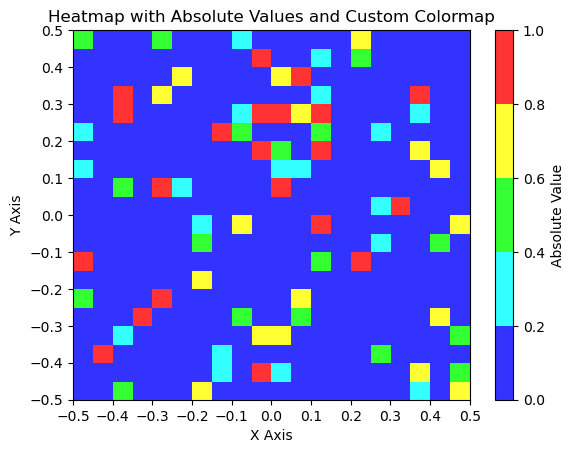

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming you have three arrays: x_array, y_array, and values_array
x_array = np.random.rand(100) - 0.5  # Replace with your actual x values
y_array = np.random.rand(100) - 0.5  # Replace with your actual y values
values_array = np.random.rand(100)  # Replace with your actual values

# Take the absolute values
values_array_abs = np.abs(values_array)

# Define the number of bins for the x and y axes
num_bins = 20

# Create a 2D histogram to find the maximum value in each bin
heatmap, xedges, yedges = np.histogram2d(x_array, y_array, bins=num_bins, weights=values_array_abs, normed=False)

# Define custom colormap
colors = [
    [0.2, 0.2, 1.0],    # [0, 0.125)
    [0.2, 1.0, 1.0],    # [0.125, 0.325)
    [0.2, 1.0, 0.2],    # [0.325, 0.625)
    [1.0, 1.0, 0.2],    # [0.625, 0.875)
    [1.0, 0.2, 0.2]     # [0.875, 1]
]

custom_cmap = ListedColormap(colors)

# Plot the heatmap with the custom colormap
plt.imshow(heatmap.T, extent=[-0.5, 0.5, -0.5, 0.5],
           origin='lower', aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)

# Add colorbar
plt.colorbar(label='Absolute Value')

# Set labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Heatmap with Absolute Values and Custom Colormap')

# Add markers on x and y axes
x_ticks = np.arange(-0.5, 0.6, 0.1)
y_ticks = np.arange(-0.5, 0.6, 0.1)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

# Show the plot
plt.show()


### Code to Export PQ LUT images by Hand

In [9]:
Test_image = c.read_image("/Volumes/T7_Shield/XX_WATCHFOLDER_LOGC4_2_PQ_HLG/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_189133.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [10]:
np.max(Test_image)

1.0

In [24]:
test_rewind_hlg_aus_PQ = c.read_image("/Users/justus/Desktop/HLG_Test/Desktop/V1-0001_Compound Clip 3_V1-0001.000010.tif")
test_rewind_pq_aus_PQ = c.read_image("/Users/justus/Desktop/PQ_Test/Desktop/V1-0001_Compound Clip 1_V1-0001.000010.tif")
test_rewind_hlg_aus_hlg = c.read_image("/Users/justus/Desktop/HLG_Test/Desktop/V1-0002_Compound Clip 4_V1-0002.000010.tif")
test_rewind_pq_aus_hlg = c.read_image("/Users/justus/Desktop/PQ_Test/Desktop/V1-0002_Compound Clip 2_V1-0002.000010.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [29]:
np.max(test_rewind_pq_aus_hlg)

0.77282369

In [34]:
test_before_resolve = c.read_image("/Users/justus/Desktop/PQ_Video_Range/Desktop/V1-0001_Testbild_PQ.000000.tif")

In [35]:
np.max(test_before_resolve)

0.70559245

In [37]:
legal2full(np.max(test_before_resolve)*1023)

0.75093730583310669

In [38]:
test_after_resolve = c.read_image("/Users/justus/Desktop/Narrow_als_Full_Export/Desktop/V1-0001_V1-0001_Testbild_PQ.000000.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [39]:
np.max(test_after_resolve)

0.75173569

In [22]:
LogC4_image = Test_image


# Log C4 LUT application
image_hlg = c.LUT3D.apply(ARRI_LogC3_LUT_1000k_DW_200_BT2020_PQ,LogC4_image)
image_pq_clipped = np.clip(image_hlg,0,1)
image_linear = c.models.eotf_ST2084(image_pq_clipped)
image_hlg_nicht_fertig = c.models.eotf_inverse_HLG_BT2100(image_hlg_clipped,0,1000)
image_clipped = np.clip(image_hlg_nicht_fertig,0,1)
image_linear2 = c.models.eotf_HLG_BT2100(image_clipped)

image_pq = c.models.eotf_inverse_ST2084(image_linear2)
image_hlg = c.models.eotf_inverse_HLG_BT2100(image_linear2,0,1000)
# Store as file
c.write_image(image_hlg,"/Users/justus/Desktop/Testbild_HLG.tiff")
c.write_image(image_pq,"/Users/justus/Desktop/Testbild_PQ.tiff")

/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/arib_std_b67.py:115: RuntimeWarning: invalid value encountered in log
  E <= 1, r * gamma_function(E, 0.5, "mirror"), a * np.log(E - b) + c
/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [23]:
LogC4_image = Test_image


# Log C4 LUT application
image_hlg = c.LUT3D.apply(ARRI_LogC3_LUT_1000k_DW_200_BT2020_HLG,LogC4_image)
image_pq_clipped = np.clip(image_hlg,0,1)
image_linear = c.models.eotf_HLG_BT2100(image_pq_clipped)

image_pq = c.models.eotf_inverse_ST2084(image_linear)
image_hlg = c.models.eotf_inverse_HLG_BT2100(image_linear,0,1000)
# Store as file
c.write_image(image_hlg,"/Users/justus/Desktop/Testbild_HLG_from_HLG.tiff")
c.write_image(image_pq,"/Users/justus/Desktop/Testbild_PQ_from_HLG.tiff")

/Users/justus/.local/lib/python3.9/site-packages/colour/models/rgb/transfer_functions/arib_std_b67.py:115: RuntimeWarning: invalid value encountered in log
  E <= 1, r * gamma_function(E, 0.5, "mirror"), a * np.log(E - b) + c
/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [18]:
np.max(image_hlg)

1.0

### Code to Reduce Images to 10 Bit Narrow Range

In [35]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/T7_Shield/XX_WATCHFOLDER_10_BIT_REDUCTION/10_SOURCE_CORRECT_UHD_selection/11.1_TRANSFORMED_PQ_FR_UHD'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_UHD = path.replace('/Volumes/T7_Shield/XX_WATCHFOLDER_10_BIT_REDUCTION','/Volumes/T7_Shield/1002_New_Reduced')
            # File Settings
            new_name_hlg_FR_UHD = os.path.join(new_path_hlg_FR_UHD,"10bit_Narrow_Range_" + name)
            # make directories
            if not os.path.exists(new_path_hlg_FR_UHD):
                os.makedirs(new_path_hlg_FR_UHD)
            print(os.path.join(path,name))

            full_range_image = c.read_image(os.path.join(path,name),bit_depth="uint16")/65535
            print(np.max(full_range_image))
            height = len(full_range_image[0,:,0])
            width = len(full_range_image[:,0,0])

            target_height = 3840
            target_width = 2160

            #full_range_linear = c.models.eotf_HLG_BT2100(full_range_image,0,1000)
            full_range_linear = c.models.eotf_ST2084(full_range_image)

            # 10 bit Narrow Range Quantization HLG
            #image_10bit_narrow = np.divide(np.round(full2legal(c.models.eotf_inverse_HLG_BT2100(full_range_linear,0,1000)),0),1023)
            image_10bit_narrow = np.divide(np.round(full2legal(c.models.eotf_inverse_ST2084(full_range_linear)),0),1023)

            # Reshape the 3D array into a 2D array with the third dimension as columns
            reshapedArray1 = full_range_linear.reshape(-1, full_range_linear.shape[2])
            reshapedArray2 = image_10bit_narrow.reshape(-1, image_10bit_narrow.shape[2])

            # Find unique values in the reshaped array
            uniqueValues1 = np.unique(reshapedArray1)
            uniqueValues2 = np.unique(reshapedArray2)
            print(np.mean(full_range_image))
            print(np.mean(image_10bit_narrow))
            print(np.min(image_10bit_narrow))
            print(np.max(image_10bit_narrow))

            # Display the number of unique values
            numUniqueValues1 = len(uniqueValues1)
            numUniqueValues2 = len(uniqueValues2)
            print('Number of different values in Original:', numUniqueValues1)
            print('Number of different values in Narrow Range:', numUniqueValues2)


            c.write_image(image_10bit_narrow,new_name_hlg_FR_UHD)


/Volumes/T7_Shield/XX_WATCHFOLDER_10_BIT_REDUCTION/10_SOURCE_CORRECT_UHD_selection/11.1_TRANSFORMED_PQ_FR_UHD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190132/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190132.tif
0.750972762646
0.186806800532
0.222523117035
0.0625610948192
0.705767350929
Number of different values in Original: 48708
Number of different values in Narrow Range: 659
/Volumes/T7_Shield/XX_WATCHFOLDER_10_BIT_REDUCTION/10_SOURCE_CORRECT_UHD_selection/11.1_TRANSFORMED_PQ_FR_UHD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_186226/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_186226.tif
0.750881208515
0.248760403767
0.275575532681
0.0625610948192
0.705767350929
Number of different values in Original: 49177
Number of different values in Narrow Range: 

KeyboardInterrupt: 

In [54]:

def double_resolution_array(image_array):
    # Get the original width and height
    original_height = 1080
    original_width = 1920

    # Double the resolution
    new_width = original_width * 2
    new_height = original_height * 2

    # Create a new array with doubled resolution
    new_image_array = np.zeros((new_height, new_width, 3), dtype=image_array.dtype)

    # Iterate through the pixels of the original array
    for y in range(original_height):
        for x in range(original_width):
            # Copy each pixel to the corresponding position in the new array
            new_image_array[y * 2, x * 2] = image_array[y, x]
            new_image_array[y * 2 + 1, x * 2] = image_array[y, x]
            new_image_array[y * 2, x * 2 + 1] = image_array[y, x]
            new_image_array[y * 2 + 1, x * 2 + 1] = image_array[y, x]

    return new_image_array


In [92]:
test1 = c.read_image("/Volumes/T7_Shield/XX_WATCHFOLDER_RESIZE/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190468/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190468.tif")
test2 = c.read_image("/Volumes/T7_Shield/NEW_TEST_HD_PQ/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_190468/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_000000.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [15]:
target_to_reduce = c.read_image("/Volumes/T7_Shield/10_SOURCE_CORRECT_UHD/12.1_TRANSFORMED_HLG_FR_UHD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_HLG_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_194641/TRANSFORMED_HLG_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_194641.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [26]:
c.models.eotf_ST2084(np.max(c.read_image("/Volumes/T7_Shield/41.1_TIFF_EXTRACTION_NEW/PQ_UHD/01_Apple_ProRes_4444/11.1_TRANSFORMED_PQ_FR_UHD/HdM-HDR-2014_Color-Graded-for-HDR_Selection/TRANSFORMED_PQ_BT2020_FR_HD_carousel_fireworks_095547.tif/Dublicated_TIFF_TRANSFORMED_PQ_BT2020_FR_HD_carousel_fireworks_095547.tif_000000.000002.tif")))

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


1076.5419348033854

In [24]:
np.max(c.read_image("/Volumes/T7_Shield/41_TIFF_EXTRACTION/31.1_PQ_UHD/02_ProRes_422HQ/13.1_TRANSFORMED_PQ_FR_HD/HdM-HDR-2014_Color-Graded-for-HDR_Selection/TRANSFORMED_PQ_BT2020_FR_HD_carousel_fireworks_095547/TRANSFORMED_PQ_BT2020_FR_HD_carousel_fireworks_095547.tif/Dublicated_TIFF_TRANSFORMED_PQ_BT2020_FR_HD_carousel_fireworks_095547.tif_000000_V1-0008.000000.tif"))

0.84794384

In [16]:
target_to_reduced_applied = c.LUT3D.apply(LUT_Limit_Gamut_BT2020_to_P3_in_2020_HLG,target_to_reduce)

In [17]:
np.max(target_to_reduced_applied-target_to_reduce)

0.72597720092010498

In [18]:
c.write_image(target_to_reduced_applied,"/Volumes/T7_Shield/TRANSFORMED_HLG_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_194641_P3.tif")

In [93]:
test2_linear = c.models.eotf_ST2084(test2)
test1_linear = c.models.eotf_ST2084(test1)
#test1_linear = c.models.eotf_HLG_BT2100(test1,0,1000)

In [94]:
np.max(np.subtract(test1_linear,test2_linear))

132.71501391011589

### Code to resize images

In [80]:
# Image Input Scaling and Encoding HLG and PQ Full Range

root = '/Volumes/T7_Shield/XX_WATCHFOLDER_RESIZE'
pattern = "*.tif"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            path = os.path.join(path)
            # Folder Settings
            new_path_hlg_FR_UHD = path.replace('/Volumes/T7_Shield/XX_WATCHFOLDER_RESIZE','/Volumes/T7_Shield/RESIZED')
            # File Settings
            new_name_hlg_FR_UHD = os.path.join(new_path_hlg_FR_UHD,name)
            # make directories
            if not os.path.exists(new_path_hlg_FR_UHD):
                os.makedirs(new_path_hlg_FR_UHD)
            print(os.path.join(path,name))

            full_range_image = c.read_image(os.path.join(path,name))
            fullrange_image_doubled = double_resolution_array(full_range_image)

            c.write_image(fullrange_image_doubled,new_name_hlg_FR_UHD)


/Volumes/T7_Shield/XX_WATCHFOLDER_RESIZE/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_185906/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_185906.tif
/Volumes/T7_Shield/XX_WATCHFOLDER_RESIZE/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_186226/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_186226.tif
/Volumes/T7_Shield/XX_WATCHFOLDER_RESIZE/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_186308/TRANSFORMED_PQ_BT2020_FR_HD_HdM_HDR_2023_VideoDisco_LogC3_AWG3_TIFF_RGB_16_bit_186308.tif
/Volumes/T7_Shield/XX_WATCHFOLDER_RESIZE/13.1_TRANSFORMED_PQ_FR_HD/20231219_HdM_HDR_2023_VideoDisco_V2_Selection/TRANSFORMED_PQ_BT202

In [50]:
test1 = c.read_image("/Volumes/T7_Shield/102.2_Source_Content_Scaled_PQ_10bit_Narrow_Range/102.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/17_A002C009_220324_R089/10bit_Narrow_Range_TRANSFORMED_PQ_BT2020_FR_UHD_A002C009_220324_R089.00000000.tif",bit_depth="uint16")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [51]:
np.max(test1)

31390

In [31]:
np.max(legal2full(test1*1023))

0.58219177

In [32]:
test2 = c.read_image("/Volumes/T7_Shield/102.1_TRANSFORMED_PQ_FR_UHD/ARRI_Encounters/2_B002C016_220405_B09C/TRANSFORMED_PQ_BT2020_FR_UHD_B002C016_220405_B09C.01513213.tif")

/Users/justus/.local/lib/python3.9/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


In [33]:
np.max(test2)

0.75181615